# Tully-Fisher Relation of galaxies

For all galaxies in Iron (Y1) which have valid rotational velocities at $0.4R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `TF_Y1_zbin_calibration_weightsVmax-1_cutsAlex_KAD.ipynb` with redshift bins of width 0.005 but with no 0pt calibration.

In [1]:
from astropy.table import Table, join
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.coordinates import Distance
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

# from cosmoprimo.fiducial import DESI

from tqdm import tqdm

import numpy as np

from scipy.stats import binned_statistic

import pickle

import os

import matplotlib.pyplot as plt

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
# sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame
from help_functions import profile_histogram

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Data

In [12]:
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI.fits')
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys_v2.fits')
SGA_TF = Table.read('SGA-2020_iron_Vrot_dVsys_VI_photsys_v2.fits')
# SGA_TF = Table.read('SGA-2020_iron_Vrot_VI_corr-20251030.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.552104184200612e-05,122.32238811543634,11.198383235519104,N
55,SGA-2020 55,PGC12039

## Morphologies

Do our results improve if we only consider spiral and irregular galaxies?

In [13]:
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other


In [14]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [15]:
SGA_TF = join(SGA_TF, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
SGA_TF['Predicted_Type'].name = 'MORPHTYPE_AI'

In [16]:
SGA_TF['SGA_ID', 'MORPHTYPE_AI'][:5]

SGA_ID,MORPHTYPE_AI
float64,str10
38.0,Spiral
55.0,Irregular
117.0,Spiral
223.0,Irregular
581.0,--


## John's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We will also remove any galaxies that John identified as having significant asymmetry, double galaxies, or stellar contamination.

In [17]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [18]:
SGA_TF = join(SGA_TF, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
SGA_TF['VI'].name = 'JOHN_VI'

## Convert to CMB frame

In [19]:
SGA_TF['Z_DESI_CMB'] = convert_z_frame(SGA_TF['Z_DESI'], SGA_TF['RA'], SGA_TF['DEC'])

## Photometric corrections

### Survey offsets

In [20]:
sys_corr, sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

### MW Dust corrections

In [21]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [22]:
MWdust_corr, MWdust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [23]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [24]:
# Apparently we have some galaxies with negative redshifts
zg0 = SGA_TF['Z_DESI'] >= 0

In [25]:
kcorr_zg0 = k_corr(SGA_TF['Z_DESI'][zg0], 
                   [SGA_TF['G_MAG_SB26'][zg0], SGA_TF['R_MAG_SB26'][zg0], SGA_TF['Z_MAG_SB26'][zg0]], 
                   [SGA_TF['G_MAG_SB26_ERR'][zg0], SGA_TF['R_MAG_SB26_ERR'][zg0], SGA_TF['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # to match FastSpecFit / FP

In [26]:
kcorr = np.zeros([len(SGA_TF), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [27]:
temp_infile = open('iron_internalDust_z0p1_mcmc_09092025.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [28]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [29]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

### Apply corrections

In [30]:
SGA_TF['G_MAG_SB26_CORR'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
SGA_TF['Z_MAG_SB26_CORR'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [31]:
SGA_TF['G_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
SGA_TF['Z_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# TFR

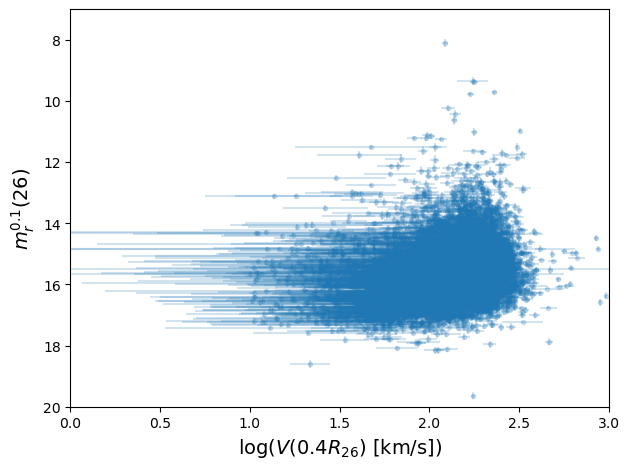

In [32]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             alpha=0.2)

plt.xlim([0, 3])
plt.ylim([20, 7])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$m_r^{0.1} (26)$', fontsize=14);

## Compute the absolute magnitudes based on the redshift

In [33]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
# cosmo = DESI()

In [34]:
SGA_TF['MU_ZCMB'] = cosmo.distmod(SGA_TF['Z_DESI_CMB'])

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['MU_ZCMB'].value

In [35]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(SGA_TF['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(SGA_TF['Z_DESI_CMB'][i]), 
                               SGA_TF['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

SGA_TF['MU_ZCMB_ERR'] = mu_err

SGA_TF['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10262/10262 [00:02<00:00, 3463.36it/s]


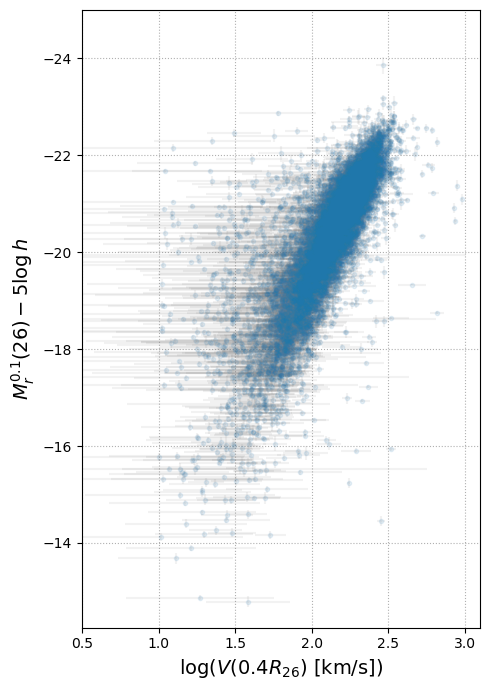

In [36]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'], 
             fmt='.', 
             alpha=0.1, 
             ecolor='gray')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

## Plotted with our TFR

### Calibration without dwarfs

Here, $V_0$, the slope, and the y-intercepts are from `TF_Y1_zbin_calibration_weightsVmax-1_cutsAlex_KAD.ipynb`:

\begin{equation}
  M_r = a \log\left(\frac{V(0.4R_{26})}{V_0}\right) + B(z_c)
\end{equation}

where $B(z_c) = b(z_c) - \mu(z_c)$, where $z_c$ is the center redshift of the relevant redshift bin.

In [37]:
temp_infile = open('cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_KAD-20250813.pickle', 
                   'rb')
cov_ab, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
temp_infile.close()

In [38]:
len(zbins)

15

In [39]:
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmo.distmod(zc)

In [40]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
ZP = np.median(tfr_samples[1:-1], axis=1) - mu_zc.value
ZP_err = np.sqrt(np.diagonal(cov_ab[1:-1,1:-1])) # Should include z-bin width to this uncertainty

sig = np.median(tfr_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
absmag = slope*(logv - logV0) + ZP

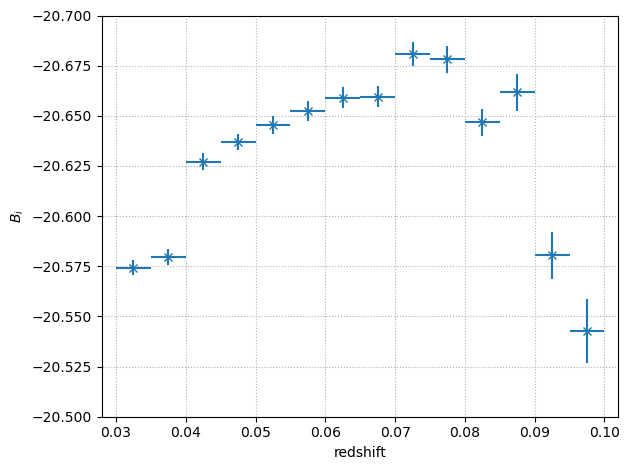

In [41]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.errorbar(zc, ZP, 
             xerr=0.5*dz, 
             yerr=ZP_err, 
             fmt='x')

plt.xlim(0.028, 0.102)
plt.ylim(-20.5, -20.7)

plt.xlabel('redshift')
plt.ylabel('$B_i$');

# plt.savefig('../../../figures/Y1_papers/TF_Y1_Bi-z_v13.png', dpi=150, facecolor='none');

In [42]:
# This cell needs to be updated for each redshift bin
'''
# Calculate the uncertainties in the calibrated TFR
slopes = tfr_samples[0]
ZPs = tfr_samples[1:-1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    # Transform zero-points
    
    lines.append(slopes[i]*(logv - V0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
''';

In [43]:
# Using Alex's notation for consistency
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

Rlim_eff = np.minimum(Rlim, SGA_TF['MU_ZCMB'] + Mlim)
dwarf_boolean = SGA_TF['R_MAG_SB26'] > Rlim_eff

In [44]:
spiral_boolean = SGA_TF['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = SGA_TF['MORPHTYPE_AI'] == 'Irregular'
# other_boolean = SGA_TF['MORPHTYPE_AI'] == 'Other'

VI_boolean = SGA_TF['JOHN_VI'].mask

morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean

In [45]:
# Alex's velocity cut
Vmin = 70 # km/s
Vmax = 300 # km/s
is_good_vel = (SGA_TF['V_0p4R26'] > Vmin) & (SGA_TF['V_0p4R26'] < Vmax)

#- Alex's sliding velocity maximum
logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)
is_good_vel2 = SGA_TF['V_0p4R26'] < np.minimum(Vmax, 10**(logVM_slope*(SGA_TF['MU_ZCMB'] - logVM_zero) + 2))

In [46]:
SGA_TF['DWARF'] = dwarf_boolean
SGA_TF['GOOD_MORPH'] = morph_boolean
SGA_TF['GOOD_VEL'] = is_good_vel & is_good_vel2

print(sum(dwarf_boolean), 'dwarfs')
print(len(SGA_TF) - sum(dwarf_boolean), 'non-dwarfs')
print('-----------')
print(sum(~dwarf_boolean & is_good_vel & is_good_vel2), "non-dwarfs that pass Alex's velocity cuts")
print('-----------')
print(np.sum(morph_boolean), 'spirals & irregulars that pass VI')
print(np.sum(morph_boolean & dwarf_boolean), 'dwarfs')
print(np.sum(morph_boolean & ~dwarf_boolean), 'non-dwarfs')

# print(sum(dwarf_boolean_corr), 'dwarfs')
# print(len(SGA_TF_corr) - sum(dwarf_boolean_corr), 'non-dwarfs')

582 dwarfs
9680 non-dwarfs
-----------
8082 non-dwarfs that pass Alex's velocity cuts
-----------
9264 spirals & irregulars that pass VI
504 dwarfs
8760 non-dwarfs


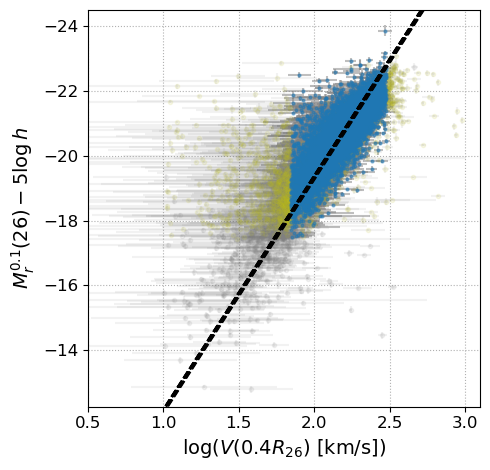

In [47]:
plt.figure(figsize=(5,4.8), tight_layout=True) # figsize was (5,7)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = dwarf_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~SGA_TF['GOOD_VEL'] & ~dwarf_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='tab:olive',
             # color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~dwarf_boolean & is_good_vel & is_good_vel2
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.5, 
             ecolor='gray')

plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../../figures/Y1_papers/iron_jointTFR_dwarfAlex_dz0p005_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

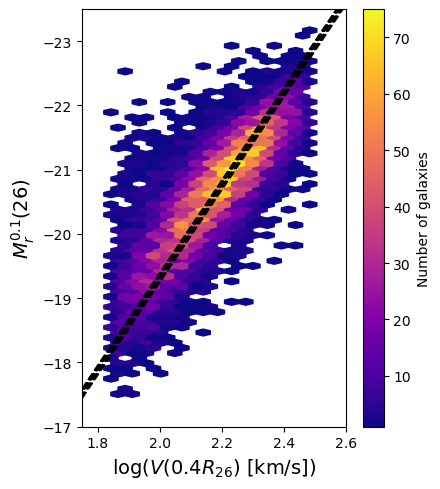

In [48]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hexbin(np.log10(SGA_TF['V_0p4R26'][~dwarf_boolean & SGA_TF['GOOD_VEL']]), 
           SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean & SGA_TF['GOOD_VEL']], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([1.75, 2.6])
plt.ylim([-17, -23.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

#### Redshift distribution

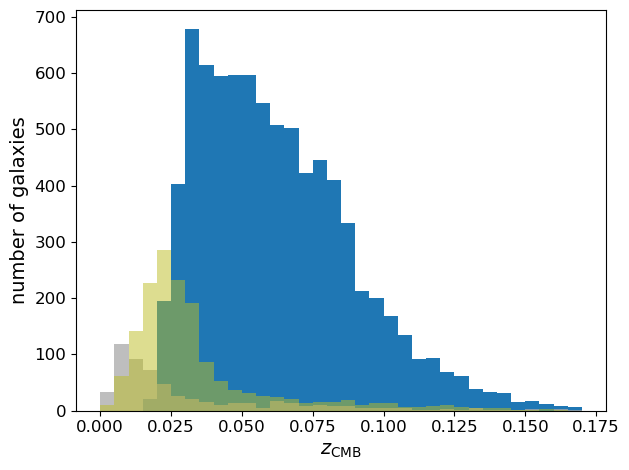

In [49]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean & SGA_TF['GOOD_VEL']],
         bins=np.arange(0, 0.175, 0.005))

plt.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean],
         bins=np.arange(0, 0.175, 0.005), 
         color='darkgray',
         alpha=0.75)

plt.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean & ~SGA_TF['GOOD_VEL']],
         bins=np.arange(0, 0.175, 0.005), 
         color='tab:olive',
         alpha=0.5)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# Distance moduli

In [50]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(SGA_TF['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
SGA_TF['R_ABSMAG_SB26_TF'] = np.nan
for i in range(len(SGA_TF)):
    SGA_TF['R_ABSMAG_SB26_TF'][i] = slope*(np.log10(SGA_TF['V_0p4R26'][i]) - logV0) + ZP[zbin_indices[i] - 1]

In [51]:
SGA_TF['R_ABSMAG_SB26_TF_ERR'] = np.nan
SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], 
                          SGA_TF['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(SGA_TF['V_0p4R26'][i]), 
    #                          0.434*SGA_TF['V_0p4R26_ERR'][i]/SGA_TF['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = slope*(np.log10(v_random[v_random > 0]) - logV0) + ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################


    # plt.figure(tight_layout=True)
    # plt.subplot(121)
    # plt.hist(np.log10(v_random[v_random > 0]), bins=100)
    # plt.xlabel('log(V)')
    # plt.title('log($\sigma_v) =$ {:.2f}'.format(np.log10(SGA_TF['V_0p4R26_ERR'][i])))
    # plt.subplot(122)
    # plt.hist(Ms_stat, bins=100)
    # plt.xlabel('$\sigma_{M_r}$ (stat)')
    # plt.title('$\sigma_M =$ {:.2f}'.format(SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i]))
    # plt.show();

    
    ############################################################################
    # Total uncertainty
    #
    # NOTE: THIS NEEDS TO BE UPDATED!
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_TF['R_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(SGA_TF['R_ABSMAG_SB26_TF_ERR']**2 - SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████████████████████████████████████████████████████████████████████████████| 10262/10262 [00:01<00:00, 8262.79it/s]


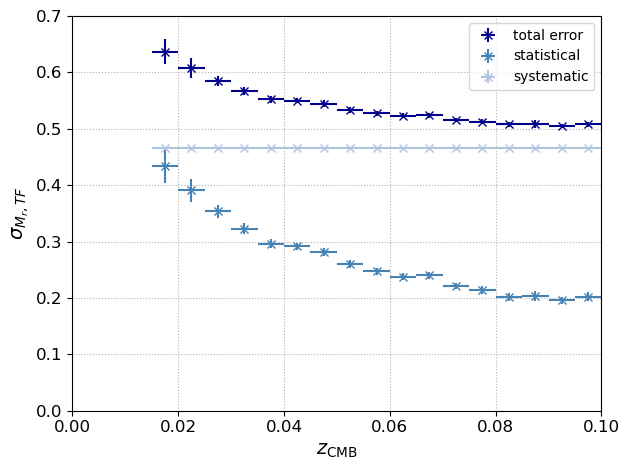

In [52]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

sample1 = ~dwarf_boolean & SGA_TF['GOOD_VEL']
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']

plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    _zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    _zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    _zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 0.7)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

## Compute distance modulus based on our TFR

In [53]:
SGA_TF['MU_TF'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_TF']

SGA_TF['MU_TF_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['R_ABSMAG_SB26_TF_ERR']**2)

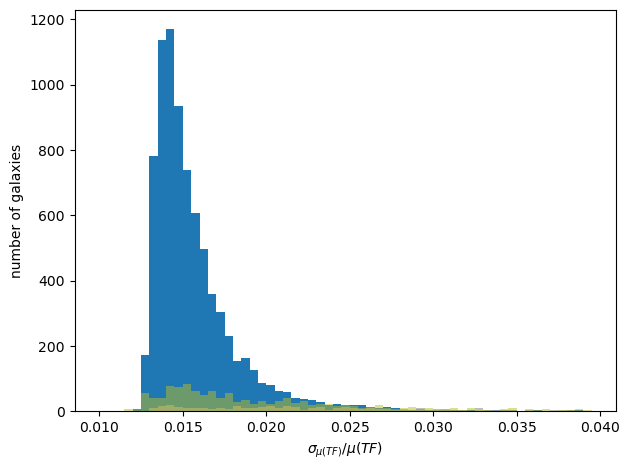

In [54]:
plt.figure(tight_layout=True)

sample1 = ~dwarf_boolean & SGA_TF['GOOD_VEL']
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']

plt.hist(SGA_TF['MU_TF_ERR'][sample1]/SGA_TF['MU_TF'][sample1], bins=np.arange(0.01, 0.04, 0.0005))
plt.hist(SGA_TF['MU_TF_ERR'][sample2]/SGA_TF['MU_TF'][sample2], bins=np.arange(0.01, 0.04, 0.0005), color='darkgray', alpha=0.75)
plt.hist(SGA_TF['MU_TF_ERR'][sample3]/SGA_TF['MU_TF'][sample3], bins=np.arange(0.01, 0.04, 0.0005), color='tab:olive', alpha=0.5)

plt.xlabel('$\sigma_{\mu(TF)} / \mu(TF)$')
plt.ylabel('number of galaxies');

## $\eta$ v. redshift

In [55]:
SGA_TF['LOGDIST'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['MU_TF'])
SGA_TF['LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['MU_TF_ERR']**2)

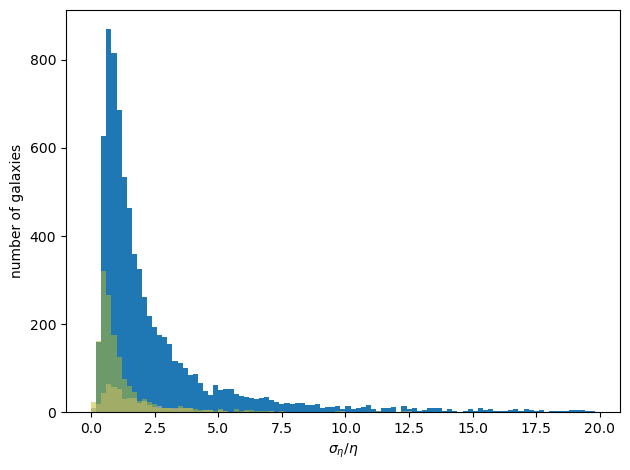

In [56]:
plt.figure(tight_layout=True)

sample1 = ~dwarf_boolean & SGA_TF['GOOD_VEL']
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']

plt.hist(SGA_TF['LOGDIST_ERR'][sample1]/np.abs(SGA_TF['LOGDIST'][sample1]), bins=np.arange(0, 20, 0.2))
plt.hist(SGA_TF['LOGDIST_ERR'][sample2]/np.abs(SGA_TF['LOGDIST'][sample2]), bins=np.arange(0, 20, 0.2), color='darkgray', alpha=0.75)
plt.hist(SGA_TF['LOGDIST_ERR'][sample3]/np.abs(SGA_TF['LOGDIST'][sample3]), bins=np.arange(0, 20, 0.2), color='tab:olive', alpha=0.5)

plt.xlabel('$\sigma_{\eta} / \eta$')
plt.ylabel('number of galaxies');

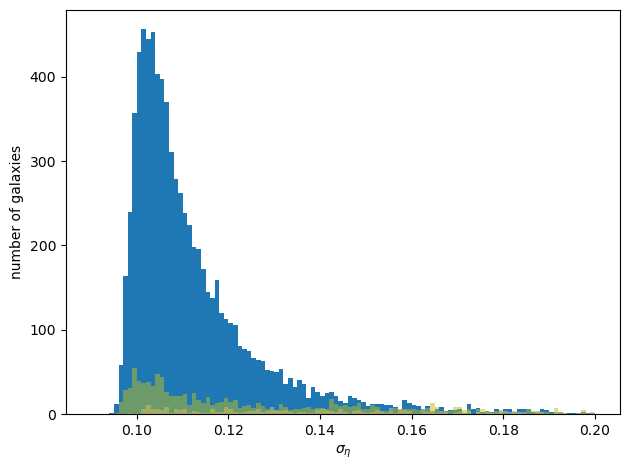

In [57]:
plt.figure(tight_layout=True)

sample1 = ~dwarf_boolean & SGA_TF['GOOD_VEL']
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']

plt.hist(SGA_TF['LOGDIST_ERR'][sample1], bins=np.arange(0.09, 0.2, 0.001))
plt.hist(SGA_TF['LOGDIST_ERR'][sample2], bins=np.arange(0.09, 0.2, 0.001), color='darkgray', alpha=0.75)
plt.hist(SGA_TF['LOGDIST_ERR'][sample3], bins=np.arange(0.09, 0.2, 0.001), color='tab:olive', alpha=0.5)

plt.xlabel('$\sigma_{\eta}$')
plt.ylabel('number of galaxies');

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/help_functions.py:62: RuntimeWarning: invalid value encountered in divide
  h = H/W
/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/help_functions.py:63: RuntimeWarning: divide by zero encountered in divide
  e = 1/np.sqrt(W)


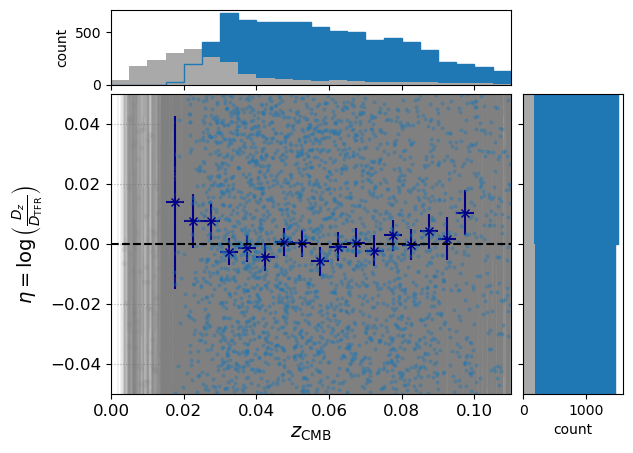

In [58]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

sample1 = ~dwarf_boolean & SGA_TF['GOOD_VEL']
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI_CMB'][~sample1], 
             SGA_TF['LOGDIST'][~sample1], 
             xerr=SGA_TF['ZERR_DESI'][~sample1], 
             yerr=SGA_TF['LOGDIST_ERR'][~sample1],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')
'''
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample3], 
             SGA_TF['LOGDIST'][sample3], 
             xerr=SGA_TF['ZERR_DESI'][sample3], 
             yerr=SGA_TF['LOGDIST_ERR'][sample3],
             fmt='.', 
             color='tab:olive',
             alpha=0.1, 
             ecolor='gray')
'''
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample1], 
             SGA_TF['LOGDIST'][sample1], 
             xerr=SGA_TF['ZERR_DESI'][sample1], 
             yerr=SGA_TF['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['LOGDIST'][sample1], 
                                    _zbins, 
                                    weights=SGA_TF['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', 
            color='darkblue', 
            # color='m',
            label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

# ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1, 1))
# ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.05, 0.05))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
'''
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample3], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:olive')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='gray', 
              histtype='step')
'''
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.05), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][~sample1], 
              bins=np.arange(-2, 2, 0.05), 
              color='darkgray', 
              orientation='horizontal')
'''
ax_histy.hist(SGA_TF['LOGDIST'][sample3], 
              bins=np.arange(-2, 2, 0.05), 
              color='tab:olive', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.05), 
              color='gray', 
              orientation='horizontal', 
              histtype='step')
'''
ax_histy.hist(SGA_TF['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.05), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../../figures/Y1_papers/iron_logdist-v-z_jointTFR-dwarfsAlex_dz0p005_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/help_functions.py:68: RuntimeWarning: invalid value encountered in divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


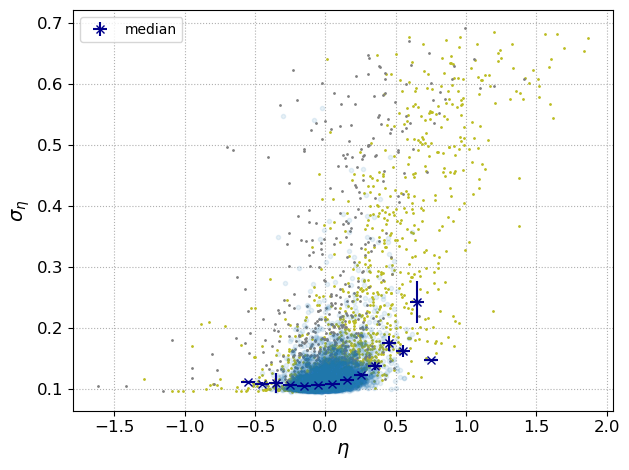

In [59]:
# Any correlation between eta and its uncertainty?
nbins = np.arange(-1.5, 1.5, 0.1)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])

sample1 = ~dwarf_boolean & SGA_TF['GOOD_VEL']
sample2 = dwarf_boolean
sample3 = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']

plt.figure(tight_layout=True)

plt.plot(SGA_TF['LOGDIST'][sample3], 
         SGA_TF['LOGDIST_ERR'][sample3], 
         '.', ms=2, color='tab:olive')

plt.plot(SGA_TF['LOGDIST'][sample2], 
         SGA_TF['LOGDIST_ERR'][sample2], 
         '.', ms=2, color='gray')

plt.plot(SGA_TF['LOGDIST'][sample1], 
         SGA_TF['LOGDIST_ERR'][sample1], 
         '.', alpha=0.1)

# Plot median
N, y_avg, y_std = profile_histogram(SGA_TF['LOGDIST'][sample1], 
                                    SGA_TF['LOGDIST_ERR'][sample1], 
                                    nbins, 
                                    median=True)
plt.errorbar(nc, y_avg, xerr=dn, yerr=y_std, fmt='x', color='darkblue', label='median')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\eta$', fontsize=14)
plt.ylabel(r'$\sigma_\eta$', fontsize=14);

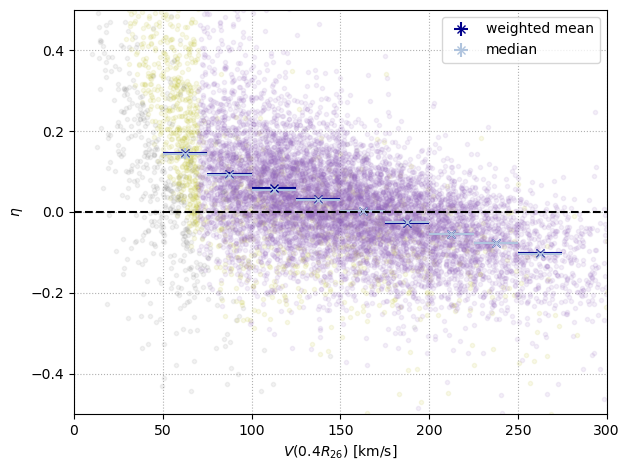

In [60]:
# logv_bins = np.arange(1.75, 2.5, 0.1)
logv_bins = np.arange(0, 300, 25) # These are really linear bins in V
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

plt.grid(ls=':')

sample = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']
# plt.plot(np.log10(SGA_TF['V_0p4R26'][sample]), 
plt.plot(SGA_TF['V_0p4R26'][sample], 
         SGA_TF['LOGDIST'][sample], 
         '.', alpha=0.1, c='tab:olive')

sample = dwarf_boolean
# plt.plot(np.log10(SGA_TF['V_0p4R26'][sample]), 
plt.plot(SGA_TF['V_0p4R26'][sample], 
         SGA_TF['LOGDIST'][sample], 
         '.', alpha=0.1, c='gray')

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL']
# plt.plot(np.log10(SGA_TF['V_0p4R26'][sample]), 
plt.plot(SGA_TF['V_0p4R26'][sample], 
         SGA_TF['LOGDIST'][sample], 
         '.', alpha=0.1, c='tab:purple')

# Plot weighted mean
# _, y_avg, y_std = profile_histogram(np.log10(SGA_TF['V_0p4R26'][sample]), 
_, y_avg, y_std = profile_histogram(SGA_TF['V_0p4R26'][sample], 
                                    SGA_TF['LOGDIST'][sample], 
                                    logv_bins, 
                                    weights=SGA_TF['LOGDIST_ERR'][sample]**-2, 
                                    weighted=True)
plt.errorbar(vc, y_avg, xerr=dv, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')

# Plot median
# _, y_avg, y_std = profile_histogram(np.log10(SGA_TF['V_0p4R26'][sample]), 
_, y_avg, y_std = profile_histogram(SGA_TF['V_0p4R26'][sample], 
                                    SGA_TF['LOGDIST'][sample], 
                                    logv_bins, 
                                    median=True)
plt.errorbar(vc, y_avg, xerr=dv, yerr=y_std, fmt='x', color='lightsteelblue', label='median')

plt.hlines(0, 0, 1000, colors='k', linestyles='dashed')

plt.legend()

plt.xlim(0, 300)
# plt.ylim(-1, 1)
plt.ylim(-0.5, 0.5)

# plt.xlabel('log($V(0.4R_{26})$)')
plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('$\eta$');

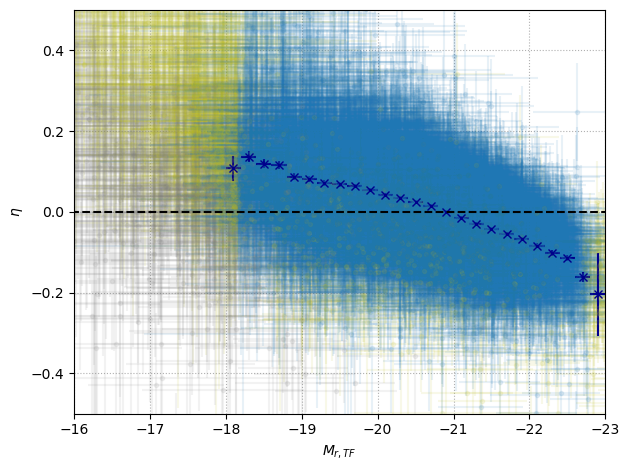

In [61]:
Mr_bins = np.arange(-23, -17, 0.2)
dMr = 0.5*np.diff(Mr_bins)
Mrc = 0.5*(Mr_bins[1:] + Mr_bins[:-1])

plt.figure(tight_layout=True)

plt.grid(ls=':')

sample = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']
plt.errorbar(SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             SGA_TF['LOGDIST'][sample], 
             xerr=SGA_TF['R_ABSMAG_SB26_TF_ERR'][sample], 
             yerr=SGA_TF['LOGDIST_ERR'][sample],
             fmt='.', 
             color='tab:olive',
             alpha=0.1)

sample = dwarf_boolean
plt.errorbar(SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             SGA_TF['LOGDIST'][sample], 
             xerr=SGA_TF['R_ABSMAG_SB26_TF_ERR'][sample], 
             yerr=SGA_TF['LOGDIST_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.1)

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL']
plt.errorbar(SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             SGA_TF['LOGDIST'][sample], 
             xerr=SGA_TF['R_ABSMAG_SB26_TF_ERR'][sample], 
             yerr=SGA_TF['LOGDIST_ERR'][sample],
             fmt='.', 
             alpha=0.1)

# Plot weighted mean
_, y_avg, y_std = profile_histogram(SGA_TF['R_ABSMAG_SB26_TF'][sample], 
                                    SGA_TF['LOGDIST'][sample], 
                                    Mr_bins, 
                                    weights=SGA_TF['LOGDIST_ERR'][sample]**-2, 
                                    weighted=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')

plt.hlines(0, -28, 0, linestyles='dashed', colors='k', zorder=10)

plt.xlim(-16, -23)
plt.ylim(-0.5, 0.5)

plt.xlabel('$M_{r,TF}$')
plt.ylabel('$\eta$');

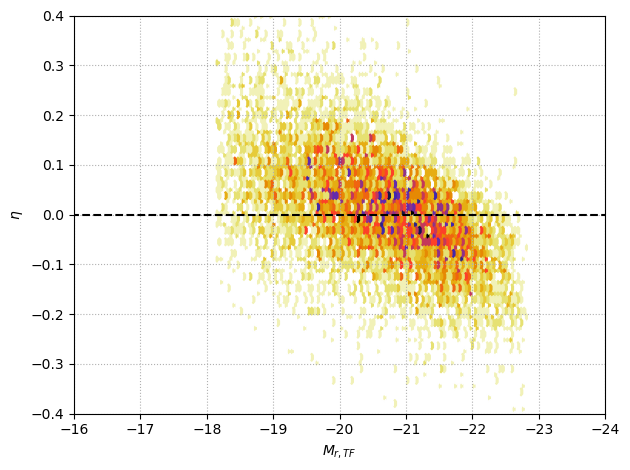

In [62]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL']
plt.hexbin(SGA_TF['R_ABSMAG_SB26_TF'][sample], 
           SGA_TF['LOGDIST'][sample], 
           cmap='CMRmap_r')

plt.hlines(0, -28, 0, linestyles='dashed', colors='k')

# plt.xlim(-18, -23)
plt.xlim(-16, -24)
plt.ylim(-0.4, 0.4)

plt.xlabel('$M_{r,TF}$')
plt.ylabel('$\eta$');

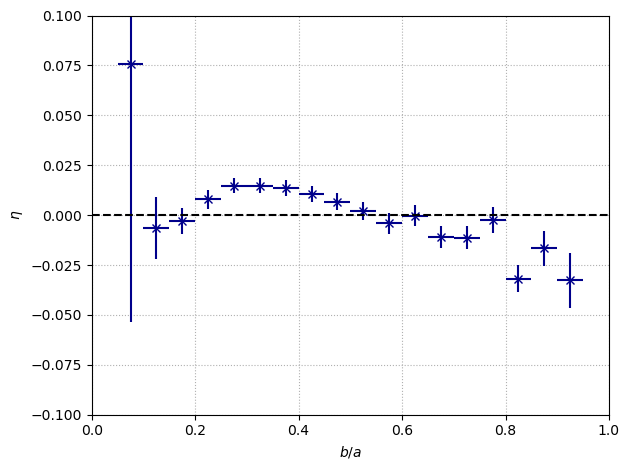

In [63]:
ba_bins = np.arange(0, 1, 0.05)
dba = 0.5*np.diff(ba_bins)
bac = 0.5*(ba_bins[1:] + ba_bins[:-1])

plt.figure(tight_layout=True)

plt.grid(ls=':')

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL']

# Plot weighted mean
_, y_avg, y_std = profile_histogram(SGA_TF['BA'][sample], 
                                    SGA_TF['LOGDIST'][sample], 
                                    ba_bins, 
                                    weights=SGA_TF['LOGDIST_ERR'][sample]**-2, 
                                    weighted=True)
plt.errorbar(bac, y_avg, xerr=dba, yerr=y_std, fmt='x', color='darkblue', label='unweighted mean')

plt.hlines(0, 0, 1, linestyles='dashed', colors='k', zorder=10)

plt.xlim(0, 1)
plt.ylim(-0.1, 0.1)

plt.xlabel('$b/a$')
plt.ylabel('$\eta$');

plt.savefig('../../../figures/Y1_papers/iron_eta-ba_v13.png', dpi=150, facecolor='none');

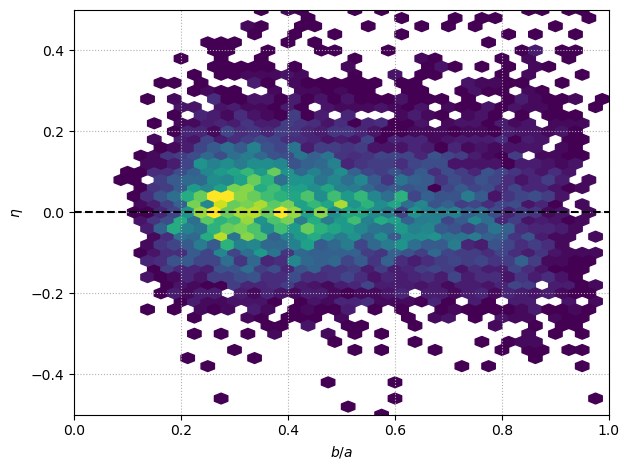

In [71]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL']
plt.hexbin(SGA_TF['BA'][sample], 
           SGA_TF['LOGDIST'][sample], 
           cmap='viridis', 
           mincnt=1, 
           vmin=1, 
           vmax=40, 
           gridsize=(40,25), 
           extent=(0,1,-0.5,0.5))

plt.hlines(0, 0, 1, linestyles='dashed', colors='k')

plt.xlim(0, 1)
plt.ylim(-0.5, 0.5)

plt.xlabel('$b/a$')
plt.ylabel('$\eta$');

## Hubble diagram

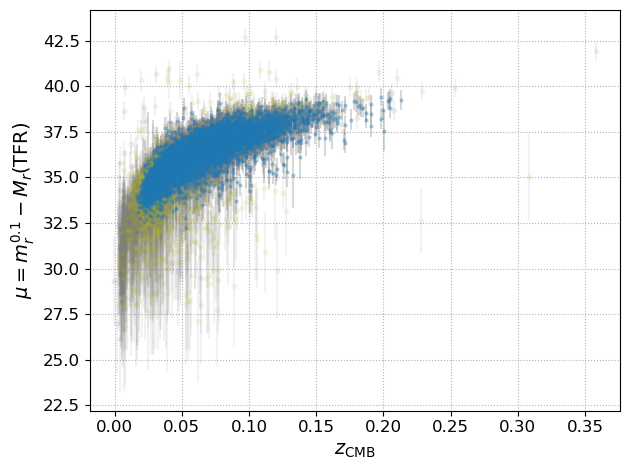

In [55]:
plt.figure(tight_layout=True)

sample = ~dwarf_boolean & ~SGA_TF['GOOD_VEL']
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample],
             SGA_TF['MU_TF'][sample],
             xerr=SGA_TF['ZERR_DESI'][sample],
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             color='tab:olive',
             alpha=0.1, 
             ecolor='gray')

sample = dwarf_boolean
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample],
             SGA_TF['MU_TF'][sample],
             xerr=SGA_TF['ZERR_DESI'][sample],
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL']
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample],
             SGA_TF['MU_TF'][sample],
             xerr=SGA_TF['ZERR_DESI'][sample],
             yerr=SGA_TF['MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

plt.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_r(\text{TFR})$', fontsize=14);

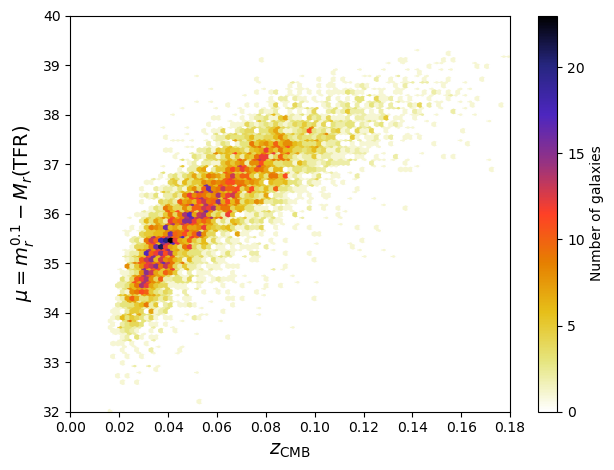

In [56]:
plt.figure(tight_layout=True)

sample = ~dwarf_boolean & SGA_TF['GOOD_VEL'] #& morph_boolean
plt.hexbin(SGA_TF['Z_DESI_CMB'][sample], 
           SGA_TF['MU_TF'][sample], 
           cmap='CMRmap_r')
plt.colorbar(label='Number of galaxies')

plt.xlim([0, 0.18])
plt.ylim([32, 40])

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_r(\text{TFR})$', fontsize=14);

## Save distance moduli to a file

In [174]:
# Create a single column to denote which objects should be used for cosmological analysis
SGA_TF['MAIN'] = ~SGA_TF['DWARF'] & SGA_TF['GOOD_VEL']

In [175]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
# hdr['0PT'] = ZP
# hdr['0PT_ERR'] = ZP_err
hdr['V0'] = logV0
hdr['SIG'] = np.median(tfr_samples[-1])
hdr['SIG_ERR'] = np.sqrt(cov_ab[-1,-1])
hdr['H0'] = H0

empty_primary = fits.PrimaryHDU(header=hdr)

In [56]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('SGA_iron_jointTFR-zbin0p005-dwarfAlex_zCMB0p1_weightsVmax-1_dVsys_moduli_20251030.fits', 
             overwrite=True)

# Comparison to the last version

In [77]:
old = Table.read(ebv_directory + 'Y1/DESI-DR1_TF_pv_cat_v13.fits')

old[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,GOOD_VEL,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,MAIN,V_PEC,VERR_PEC
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,bytes10,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.0282255

In [127]:
old_new = join(old['SGA_ID', 'LOGDIST', 'LOGDIST_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'R_MAG_SB26_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_TF'], 
               SGA_TF['SGA_ID', 'LOGDIST', 'LOGDIST_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'R_MAG_SB26_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_TF', 'Z_DESI'], 
               keys='SGA_ID', 
               table_names=['old', 'new'])

old_new[:5]

SGA_ID,LOGDIST_old,LOGDIST_ERR_old,V_0p4R26_old,V_0p4R26_ERR_old,R_MAG_SB26_CORR_old,R_ABSMAG_SB26_old,R_ABSMAG_SB26_TF_old,LOGDIST_new,LOGDIST_ERR_new,V_0p4R26_new,V_0p4R26_ERR_new,R_MAG_SB26_CORR_new,R_ABSMAG_SB26_new,R_ABSMAG_SB26_TF_new,Z_DESI
,,,,,,,,mag,mag,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
38.0,0.0711702952911594,0.1079084335961595,122.3223893029039,9.671537005812278,16.728901859968826,-20.34231302345913,-19.986461547003334,0.07046263333291307,0.1079861278597384,122.3223893029039,11.199286747864958,16.72591931744365,-20.344736162596863,-19.992422995932298,0.0809898865247745
55.0,0.030331156588198384,0.11251101560076007,81.3789130370326,7.725161740109695,16.87676460899331,-18.849995149542853,-18.69833936660186,0.029146187756447263,0.10353652588729274,81.31490064859103,6.544236935177211,16.874275412887908,-18.852175305555935,-18.7064443667737,0.0440016373089485
117.0,0.04644331091951415,0.10544196481039624,180.6557315191658,12.555107762887319,15.954404164953896,-21.371783346669563,-21.139566792071996,0.04760221183577756,0.10266696023258813,180.6557315191658,13.703729472844426,15.951266535825447,-21.37429607245837,-21.136285013279487,0.0900398334789895
223.0,0.0679350753513475,0.13648647929881474,70.1020042633194,10.55954809258847,16.643691575528077,-18.507775175927126,-18.16809979917039,0.06622444140088533,0.14286962736282294,70.1020042633194,12.017192541858238,16.640999644260333,-18.5102282625017,-18.179106055497275,0.0340259256442166
581.0,0.04406468107029582,0.10955408263893825,133.77852107143553,10.574319515162813,15.209917450108733,-20.465532366168695,-20.245208960817216,0.04411201622873193,0.1060607125255224,133.77852107143553,10.96714989369019,15.205983515976115,-20.469164258352365,-20.2486041772087,0.0433192742619632


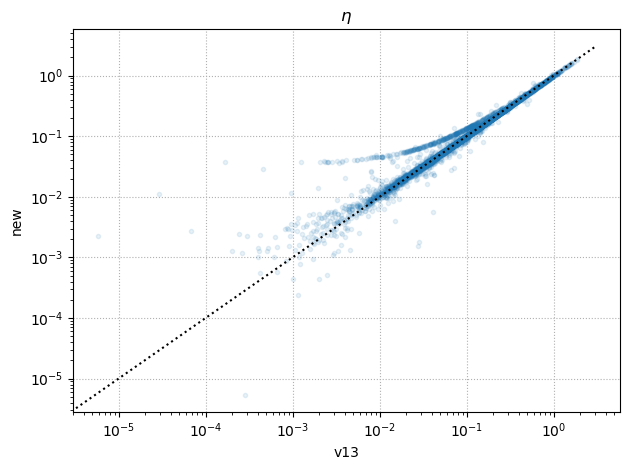

In [80]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.loglog(old_new['LOGDIST_old'], old_new['LOGDIST_new'], '.', alpha=0.1)

plt.loglog([-0.5, 3], [-0.5, 3], 'k:')

plt.title('$\eta$')
plt.xlabel('v13')
plt.ylabel('new');

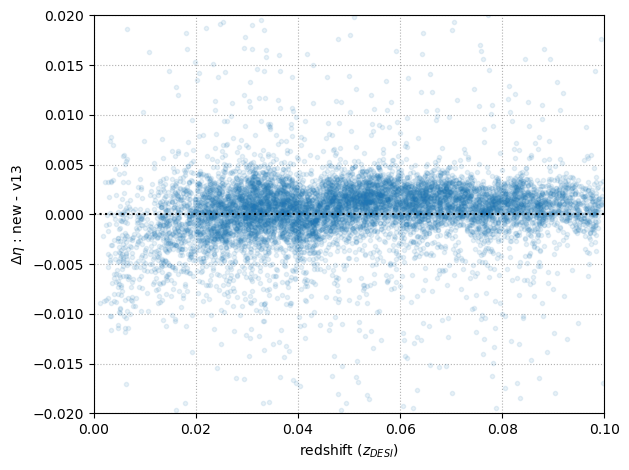

In [147]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(old_new['Z_DESI'], old_new['LOGDIST_new'] - old_new['LOGDIST_old'], '.', alpha=0.1)

plt.hlines(0, 0, 0.2, colors='k', linestyles='dotted')

plt.xlim(0, 0.1)
plt.ylim(-0.02, 0.02)

plt.xlabel('redshift ($z_{DESI}$)')
plt.ylabel('$\Delta \eta$ : new - v13');

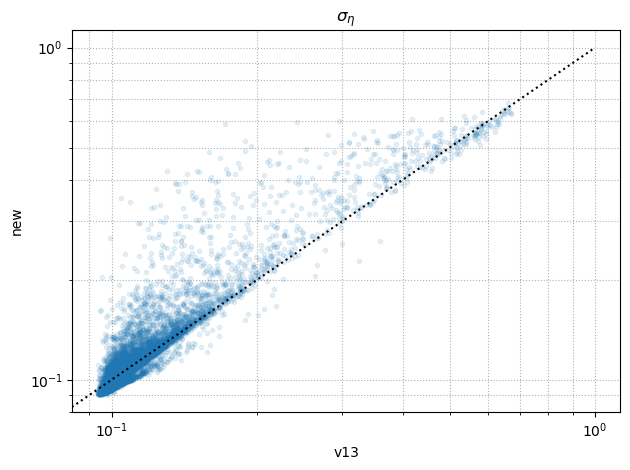

In [82]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

plt.loglog(old_new['LOGDIST_ERR_old'], old_new['LOGDIST_ERR_new'], '.', alpha=0.1)

plt.loglog([-0.5, 1], [-0.5, 1], 'k:')

plt.title('$\sigma_\eta$')
plt.xlabel('v13')
plt.ylabel('new');

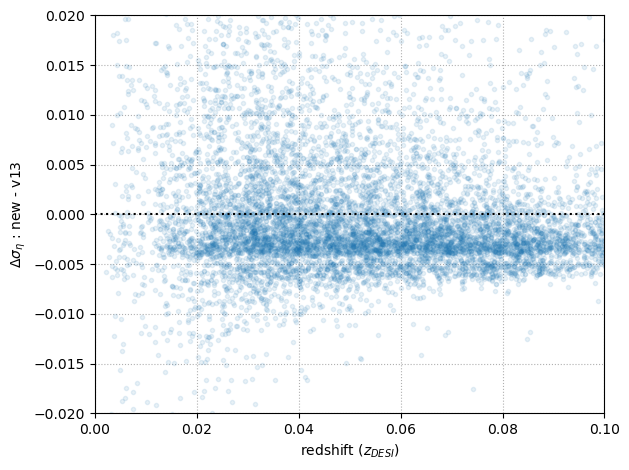

In [150]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(old_new['Z_DESI'], old_new['LOGDIST_ERR_new'] - old_new['LOGDIST_ERR_old'], '.', alpha=0.1)

plt.hlines(0, 0, 0.2, colors='k', linestyles='dotted')

plt.xlim(0, 0.1)
plt.ylim(-0.02, 0.02)

plt.xlabel('redshift ($z_{DESI}$)')
plt.ylabel('$\Delta \sigma_\eta$ : new - v13');

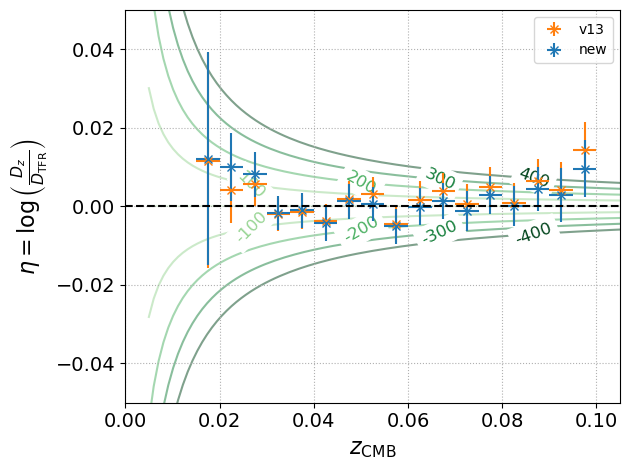

In [173]:
plt.figure(tight_layout=True)

_zbins = np.arange(0, 0.105, 0.005)
_dz = 0.5*np.diff(_zbins)
_zc = 0.5*(_zbins[1:] + _zbins[:-1])

# Plot the original catalog
N, y_avg, y_std = profile_histogram(old['Z_DESI_CMB'][old['MAIN']], 
                                    old['LOGDIST'][old['MAIN']], 
                                    _zbins, 
                                    weights=old['LOGDIST_ERR'][old['MAIN']]**-2, 
                                    weighted=True)
plt.errorbar(_zc, y_avg, xerr=_dz, yerr=y_std, fmt='x', 
             color='tab:orange', 
             label='v13')

# Plot the new catalog
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][SGA_TF['MAIN']], 
                                    SGA_TF['LOGDIST'][SGA_TF['MAIN']], 
                                    _zbins, 
                                    weights=SGA_TF['LOGDIST_ERR'][SGA_TF['MAIN']]**-2, 
                                    weighted=True)
plt.errorbar(_zc, y_avg, xerr=_dz, yerr=y_std, fmt='x', 
             color='tab:blue', 
             label='new')

#-------------------------------------------------------------------------------
# PV lines (code taken from Cullen)
#-------------------------------------------------------------------------------
velarray = np.arange(-400, 401, 100)
zarray = np.linspace(0.005, 0.21, 200)

dzarray = cosmo.comoving_distance(zarray).value
dharray = cosmo.comoving_distance(np.outer(1.0/(1.0 + velarray/c.value), 
								  (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/c.value)
ycoord = np.array([deltamarray[i,j] for i, j in enumerate(coord)])

colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

for v in range(len(velarray)):
    col = plt.cm.Greens(colors[v])

    plt.plot(zarray, deltamarray[v,:], 
             color=col, 
             linestyle='-', 
             alpha=0.5, 
             zorder=0)

    if (v != 4):
        plt.text(xcoord[v]/c.value, ycoord[v], 
                 labels[v], 
                 color=col, 
                 fontsize=12, 
                 rotation=rotation[v], 
                 ha="center", 
                 va="center", 
                 bbox=dict(boxstyle="square", ec="w", fc="w"), 
                 zorder=1)

# Line at eta = 0
plt.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)
#-------------------------------------------------------------------------------

plt.grid(ls=':')

# plt.vlines([0.03, 0.1], -0.05, 0.05, colors='gray', linestyles='dashed')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=16)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', 
           fontsize=16)

plt.ylim((-0.05, 0.05))
# plt.ylim((-0.13, 0.13))
plt.xlim((0, 0.105))
# plt.xlim((0, 0.2))

plt.legend();

In [134]:
high_z = (old_new['Z_DESI'] > 0.1) & (old_new['Z_DESI'] < 0.105)
old_new[high_z]

SGA_ID,LOGDIST_old,LOGDIST_ERR_old,V_0p4R26_old,V_0p4R26_ERR_old,R_MAG_SB26_CORR_old,R_ABSMAG_SB26_old,R_ABSMAG_SB26_TF_old,LOGDIST_new,LOGDIST_ERR_new,V_0p4R26_new,V_0p4R26_ERR_new,R_MAG_SB26_CORR_new,R_ABSMAG_SB26_new,R_ABSMAG_SB26_TF_new,Z_DESI
,,,,,,,,mag,mag,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3391.0,-0.05204988850965009,0.10300296088108717,189.03220595136116,9.843640119482663,16.435193932293366,-21.155854341890617,-21.41610378443887,-0.016477220708706854,0.09959001933062735,189.03220595136116,10.479352555713016,16.43109075640142,-21.15925697354101,-21.24164307708454,0.101650477463242
4134.0,0.2727403258800635,0.17441157670213028,118.5384366920823,25.31154808407209,16.308091912683523,-21.318036826618744,-19.954335197218423,0.3056736921435004,0.18029983465491578,118.5384366920823,27.527143064105925,16.305180081286565,-21.32023747536502,-19.791869014647514,0.10351932936603
7426.0,0.010869986101752716,0.10345763169563074,173.9601879641586,10.099586591061412,16.388636998788634,-21.210190402742974,-21.15584047223421,0.04591891858316899,0.1002768592197642,173.9601879641586,10.789629811049954,16.385014565809552,-21.213109945313295,-20.983515352397454,0.10134402943135398
9769.0,-0.011009753867850237,0.09503113348677945,158.60857487391618,1.8642315363475128,16.75054960191181,-20.811410298690564,-20.866459068029815,0.023235106105842365,0.09185983559858857,158.61828837149366,4.316519271145217,16.74839343062824,-20.812874240902765,-20.696698710373553,0.10073830482947473
13560.0,-0.01837979309319735,0.10624512767923894,202.613463097429,13.59668798325936,16.08824944741796,-21.541530037051405,-21.63342900251739,0.0175265905042437,0.10238871704418157,202.613463097429,13.981138444507382,16.084249197889303,-21.544817988188147,-21.457185035666928,0.102882106682273
14051.0,-0.02902488762301232,0.0971732901875985,251.1923423147706,6.596850755708689,15.474409973496844,-22.16148879969032,-22.30661323780538,0.0118026889717612,0.09259508064212368,249.57437498437233,6.060415106300079,15.471400286217605,-22.16378431473333,-22.104770869874528,0.102924206219254
15262.0,-0.09955630071693095,0.10269185262109336,195.52053025165486,10.301907207359012,16.551919730097644,-21.024030112835966,-21.52181161642062,-0.06389352710545496,0.09930139057009457,195.52053025165486,11.135847905722565,16.548237942289447,-21.027015889178998,-21.346483524706276,0.100752834935146
15938.0,-0.2144636449906983,0.09829128994913042,361.43989253947893,14.464860970527788,15.212851470575186,-22.37405572958076,-23.446373954534252,-0.17590115498117315,0.09526869145280624,361.43989253947893,17.093166946726367,15.21045978736233,-22.37574811450351,-23.255253889409374,0.101606454521101


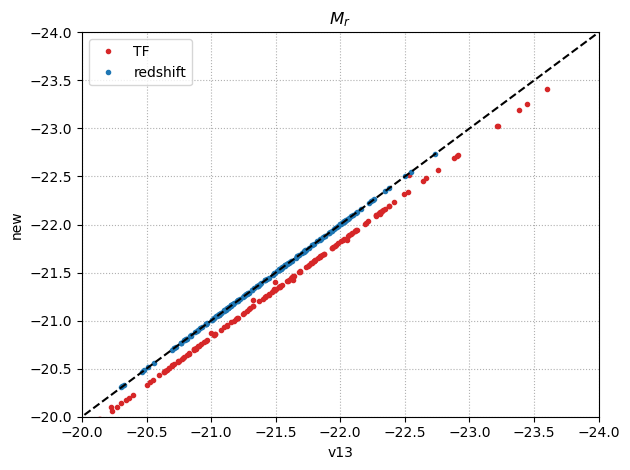

In [143]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(old_new['R_ABSMAG_SB26_TF_old'][high_z], old_new['R_ABSMAG_SB26_TF_new'][high_z], '.', c='tab:red', label='TF')
plt.plot(old_new['R_ABSMAG_SB26_old'][high_z], old_new['R_ABSMAG_SB26_new'][high_z], '.', c='tab:blue', label='redshift')

plt.plot([-27, -12], [-27, -12], 'k--')

plt.legend()

plt.xlim((-20, -24))
plt.ylim((-20, -24))

plt.title('$M_r$')
plt.xlabel('v13')
plt.ylabel('new');

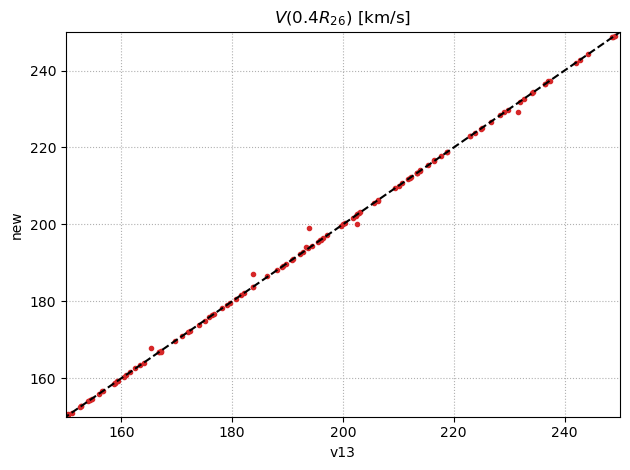

In [141]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(old_new['V_0p4R26_old'][high_z], old_new['V_0p4R26_new'][high_z], '.', c='tab:red')

plt.plot([0, 500], [0, 500], 'k--')

plt.xlim((150, 250))
plt.ylim((150, 250))

plt.title('$V(0.4R_{26})$ [km/s]')
plt.xlabel('v13')
plt.ylabel('new');